<a href="https://colab.research.google.com/github/L-Quintana/Cromoforos/blob/main/gap_nn_qm9_DeepChem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalando DeepChem

In [1]:
# Conda contiene una serie de herramientas de colab, incluidas Pandas , Scikit-Learn , PyTorch, etc.

!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3501  100  3501    0     0   8818      0 --:--:-- --:--:-- --:--:--  8818


add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.11
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added conda-forge to channels
added omnia to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda



In [2]:
!pip install kora
import kora.install.rdkit

     |████████████████████████████████| 57 kB 2.3 MB/s 
     |████████████████████████████████| 56 kB 3.1 MB/s 


In [3]:
!pip install --pre deepchem

     |████████████████████████████████| 597 kB 4.2 MB/s 


In [4]:
import deepchem as dc
dc.__version__

'2.6.0.dev'

Importar librerías

In [5]:
import sys # El módulo sys es el encargado de proveer variables y funcionalidades, directamente relacionadas con el intérprete (python). Es una lista de directorios/carpetas donde Python busca los módulos cuando realizamos un import.
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

!python --version

Python 3.7.11


In [6]:
import numpy as np
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

#qm9 dataset

In [7]:
dataset_file = "/content/gdb9.sdf"  #Hay que subir ambos archivos(gdb9.sdf y gdb9.sdf.csv ) para que funcione esta celda
tasks=['gap']
#tasks=['mu','alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'cv', 'u0', 'u298', 'h298', 'g298']

In [8]:
#Eigenvalores de Matriz de Coulomb (empleando method randomize_coulomb_matrices to randomize Coulomb matrices)
featurizer = dc.feat.CoulombMatrixEig(29, remove_hydrogens=False, randomize= True) 

In [9]:
loader = dc.data.SDFLoader(
      tasks=['gap'],
      featurizer=featurizer)
dataset = loader.create_dataset(dataset_file)

/usr/local/lib/python3.7/dist-packages/deepchem/feat/molecule_featurizers/coulomb_matrices.py:146: RuntimeWarning: divide by zero encountered in true_divide
  m = np.outer(z, z) / d


In [10]:
dataset #Todo el conjunto de datos sin transformar

<DiskDataset X.shape: (133885, 29), y.shape: (133885, 1), w.shape: (133885, 1), task_names: ['gap']>

```
transformers = [
    dc.trans.NormalizationTransformer(transform_X=True, dataset=train_dataset),
    dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset]:
  for transformer in transformers:
      dataset = transformer.transform(dataset)
```



In [11]:
transformers = [
    dc.trans.NormalizationTransformer(transform_X=True, dataset=dataset),
    dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset)]

for transformer in transformers:
  dataset = transformer.transform(dataset)

In [12]:
random_splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = random_splitter.train_valid_test_split(dataset)

Estructura de los datasets

In [13]:
dataset

<DiskDataset X.shape: (133885, 29), y.shape: (133885, 1), w.shape: (133885, 1), task_names: ['gap']>

In [14]:
transformers

In [15]:
tasks

['gap']

In [16]:
#Conjunto de prueba
test_dataframe=test_dataset.to_dataframe()
test_dataframe

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,y,w,ids
0,-0.353197,-0.973397,-0.116120,-0.256034,-0.251900,0.582164,-0.938224,0.063507,0.292885,-0.514381,-0.289469,-0.065625,-0.521141,-0.054473,-0.163449,0.063134,-1.495017,-1.134231,-0.870068,-0.646761,-0.502246,-0.339881,-0.27482,-0.153325,-0.134092,-0.058008,-0.05407,-0.01616,-0.016158,-0.692917,1.0,[H]C1=C([H])N([H])C2=C1/C(N([H])[H])=C(/[H])N2[H]
1,-1.005893,0.110626,-1.212762,-0.670895,-0.890698,-0.494929,-0.625707,0.119757,-2.213362,-1.152566,0.402132,-0.077382,-0.154438,0.130647,0.275132,0.457978,0.631634,0.816033,0.857921,-0.646761,-0.502246,-0.339881,-0.27482,-0.153325,-0.134092,-0.058008,-0.05407,-0.01616,-0.016158,-1.440794,1.0,[H]C(=O)C([H])([NH+]1C([H])([H])C1([H])C([H])(...
2,0.327742,0.213650,0.142618,1.615726,0.151433,0.615906,0.380624,0.022698,0.391362,-0.635135,-1.470737,-0.921140,-0.323088,-0.683826,-2.624999,-1.969845,-1.495017,-1.134231,-0.870068,-0.646761,-0.502246,-0.339881,-0.27482,-0.153325,-0.134092,-0.058008,-0.05407,-0.01616,-0.016158,-0.207699,1.0,[H][N-]C1OC([H])([H])C12N([H])C2([H])C#N
3,1.532409,1.034682,0.020341,0.912933,2.410957,1.140556,2.241870,0.756861,0.684884,-0.747399,-0.290260,-1.306041,-0.622451,-0.690252,-2.624999,-1.969845,-1.495017,-1.134231,-0.870068,-0.646761,-0.502246,-0.339881,-0.27482,-0.153325,-0.134092,-0.058008,-0.05407,-0.01616,-0.016158,-0.949561,1.0,[H]/N=C(/OC([H])([H])[H])N1N=NN=C1[H]
4,-0.671298,-0.236395,0.677769,0.633144,0.218371,0.045850,0.361226,0.399768,0.496914,1.150271,0.808944,0.675407,0.696754,0.813351,0.536382,0.696508,0.619080,0.856339,1.046756,1.367659,1.804284,-0.339881,-0.27482,-0.153325,-0.134092,-0.058008,-0.05407,-0.01616,-0.016158,2.432930,1.0,[H]OC([H])([H])C([H])(C#N)N([H])C([H])([H])C([...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13384,-0.050565,-0.799271,-0.165383,-0.510093,-0.158801,-0.159959,-0.095281,0.063097,0.422237,0.568082,0.146339,0.269728,0.227866,0.064309,0.253752,0.315618,0.482240,0.785076,-0.870068,-0.646761,-0.502246,-0.339881,-0.27482,-0.153325,-0.134092,-0.058008,-0.05407,-0.01616,-0.016158,0.030900,1.0,[H]C([H])([H])C1([H])C([H])([H])C2(C#N)OC1([H]...
13385,-0.314708,0.076256,-0.354894,-0.014495,-0.513486,-1.205730,-1.024044,-0.302095,-2.232788,-1.675560,-1.200007,-1.278203,-0.964140,-0.723382,-2.624999,-1.969845,-1.495017,-1.134231,-0.870068,-0.646761,-0.502246,-0.339881,-0.27482,-0.153325,-0.134092,-0.058008,-0.05407,-0.01616,-0.016158,-1.611222,1.0,[H]C(=O)N1C([H])=C([H])C([H])=C1N([H])[H]
13386,2.028780,2.502134,1.188620,1.993695,2.551787,2.303492,-0.099529,0.298092,0.351089,-1.776557,-1.617274,-1.068257,-0.626552,-3.507759,-2.624999,-1.969845,-1.495017,-1.134231,-0.870068,-0.646761,-0.502246,-0.339881,-0.27482,-0.153325,-0.134092,-0.058008,-0.05407,-0.01616,-0.016158,0.273509,1.0,[H][N-]C1=[N+]([H])C(O[H])=NC([H])=C1F
13387,0.295330,1.314791,0.520005,0.638682,0.203164,-0.318914,0.623145,0.127926,0.297080,-0.234532,0.254981,-0.329968,-0.576376,-0.123882,0.228795,0.073252,-1.495017,-1.134231,-0.870068,-0.646761,-0.502246,-0.339881,-0.27482,-0.153325,-0.134092,-0.058008,-0.05407,-0.01616,-0.016158,-0.903445,1.0,[H]C(=O)C1=C(C([H])([H])[H])C(=O)N([H])C1([H])[H]


# Hyperparameter Optimization for the model: ¨MultitaskRegressor¨

In [17]:
#Param_default:weight_init_stddevs=0.02; bias_init_consts=1.0;weight_decay_penalty=0.0~=0.0001;weight_decay_penalty_type='l2';activation_fns=relu.
params_dict = {'n_tasks': [len(tasks)],'n_features': [29],'layer_sizes': [[500], [1000], [1000, 1000], [2000, 900, 800], [2500, 500, 500, 1000], [2000, 800, 800, 1000]],'dropouts': [0.05, 0.1, 0.2, 0.5],'learning_rate': [0.0001, 0.001, 0.0025, 0.005, 0.01, 0.1], 'nb_epoch': [10]} 
optimizer = dc.hyper.GridHyperparamOpt(dc.models.MultitaskRegressor)
metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)
best_model, best_hyperparams, all_results = optimizer.hyperparam_search(params_dict, train_dataset, valid_dataset, output_transformers=transformers, metric=metric, use_max=False, optimizer_type = 'GradientDescent')


In [18]:
all_results

{'_dropouts_0.050000_layer_sizes[1000, 1000]_learning_rate_0.000100_n_features_29_n_tasks_1_nb_epoch_10': 0.040543119754304136,
 '_dropouts_0.050000_layer_sizes[1000, 1000]_learning_rate_0.001000_n_features_29_n_tasks_1_nb_epoch_10': 0.04038963194618785,
 '_dropouts_0.050000_layer_sizes[1000, 1000]_learning_rate_0.002500_n_features_29_n_tasks_1_nb_epoch_10': 0.040472287849636544,
 '_dropouts_0.050000_layer_sizes[1000, 1000]_learning_rate_0.005000_n_features_29_n_tasks_1_nb_epoch_10': 0.04069751128525199,
 '_dropouts_0.050000_layer_sizes[1000, 1000]_learning_rate_0.010000_n_features_29_n_tasks_1_nb_epoch_10': 0.04097726740794707,
 '_dropouts_0.050000_layer_sizes[1000, 1000]_learning_rate_0.100000_n_features_29_n_tasks_1_nb_epoch_10': 0.04149047873545188,
 '_dropouts_0.050000_layer_sizes[1000]_learning_rate_0.000100_n_features_29_n_tasks_1_nb_epoch_10': 0.0409700747254806,
 '_dropouts_0.050000_layer_sizes[1000]_learning_rate_0.001000_n_features_29_n_tasks_1_nb_epoch_10': 0.04040531529458

In [19]:
best_model

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


MultitaskRegressor(activation_fns=None, bias_init_consts=None, dropouts=None,
                   layer_sizes=None, n_features=29, n_tasks=1, residual=None,
                   uncertainty=None, weight_decay_penalty=None,
                   weight_decay_penalty_type=None, weight_init_stddevs=None)

In [20]:
best_hyperparams

(1, 29, [1000], 0.05, 0.0025, 10)

**- Early Stopping:** To obtain the correct number of epoch.

We just train it once, monitor the validation score, and keep whichever parameters maximize it. This is called **"early stopping"**. DeepChem's ValidationCallback class compute the validation set's  mean_absolute_error every 500 training steps. If you add the save_dir argument, it will also save a copy of the best model parameters to disk.

Overfitting happens when the validation set score stops increasing and may even decrease, while the score on the training set continues to improve.

In [21]:
#model = dc.models.MultitaskRegressor(n_tasks=len(tasks), n_features=29, layer_sizes=[1000], dropouts=0.1, learning_rate=0.001, optimizer_type = 'GradientDescent')
metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)
#callback = dc.models.ValidationCallback(valid_dataset, 500, metric)
#model.fit(train_dataset, nb_epoch=200, callbacks=callback)

model = dc.models.MultitaskRegressor(n_tasks=len(tasks), n_features=29, layer_sizes=[1000], dropouts=0.2, learning_rate=0.0001,metric=metric, optimizer_type = 'GradientDescent')
model.fit(train_dataset, nb_epoch=20)  #, output_transformers=transformers

1.0120444297790527

**- Learning Rate Schedules:** To vary the learning rate during training 

In [22]:
#learning_rate1 = dc.models.optimizers.ExponentialDecay(0.0002, 0.9, 1000)
#model = dc.models.MultitaskRegressor(n_tasks=len(tasks), n_features=23, layer_sizes=[500], dropouts=0.1, learning_rate=learning_rate1, optimizer_type = 'GradientDescent', output_transformers=transformers)
#model.fit(train_dataset, nb_epoch=200, callbacks=callback)

#Evaluate the performance of the model trained. 

In [23]:
metric1 = dc.metrics.Metric(dc.metrics.pearson_r2_score)
metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)

print("Training set:", model.evaluate(train_dataset, [metric, metric1], transformers))  
print("Test set:", model.evaluate(test_dataset, [metric, metric1], transformers))   
print("Validation set:", model.evaluate(valid_dataset, [metric, metric1], transformers))    

Training set: {'mean_absolute_error': 0.04101383929186455, 'pearson_r2_score': 0.01650666435454469}
Test set: {'mean_absolute_error': 0.040889072366183166, 'pearson_r2_score': 0.02041755327974712}
Validation set: {'mean_absolute_error': 0.04081131538139032, 'pearson_r2_score': 0.017534823528391454}


#Predictions

- Test set

In [24]:
test_prediction= model.predict(test_dataset, transformers)
test_prediction

array([[[0.25424398]],

       [[0.25390451]],

       [[0.2505218 ]],

       ...,

       [[0.25871916]],

       [[0.2547558 ]],

       [[0.25402952]]])

In [25]:
test_prediction.shape

(13389, 1, 1)

Revertir la transformación

In [26]:
def undo_transforms(y, transformers):
  """Undoes all transformations applied."""
  # Note that transformers have to be undone in reversed order
  for transformer in reversed(transformers):
    if transformer.transform_y:
      y = transformer.untransform(y)
  return y

In [27]:
test_real=undo_transforms(test_dataset.y, transformers=transformers)
test_real

array([[0.2221],
       [0.1848],
       [0.2463],
       ...,
       [0.2703],
       [0.2116],
       [0.3238]])

Text(0.5, 1.0, 'predichos vs. valores reales')

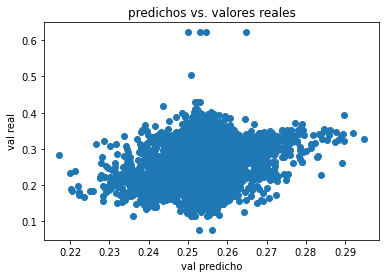

In [28]:
plt.scatter(test_prediction,test_real)
plt.xlabel('val predicho')
plt.ylabel('val real')
plt.title(r'predichos vs. valores reales')

- Validation set

In [29]:
valid_prediction= model.predict(valid_dataset, transformers)
valid_prediction

array([[[0.25280966]],

       [[0.2581301 ]],

       [[0.26008299]],

       ...,

       [[0.25533522]],

       [[0.25239091]],

       [[0.25196305]]])

In [30]:
valid_real=undo_transforms(valid_dataset.y, transformers=transformers)
valid_real

array([[0.2929],
       [0.2386],
       [0.2487],
       ...,
       [0.324 ],
       [0.2418],
       [0.2316]])

Text(0.5, 1.0, 'predichos vs. valores reales')

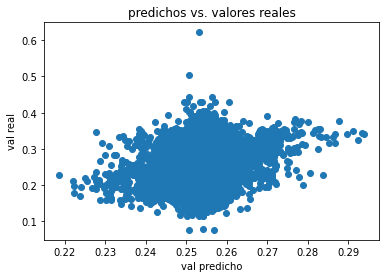

In [31]:
plt.scatter(valid_prediction,valid_real)
plt.xlabel('val predicho')
plt.ylabel('val real')
plt.title(r'predichos vs. valores reales')